# Executive Summary

The aim of the project is to investigate whether we could find quantitative features that allow us to predict the happiness score better than using the original predominately survey-based data (qualitative). 

Evaluating metrics were various R2 scores and RMSE scores for our models. 

We could achieve significant results by using our own features, which were less biased because of their quantitative nature.

There was less variance using quantitative features instead of the qualitative features from the original dataset. The same held true for accuracy score of our quantitative features when compared to the model run with the qualitative (original data) features.

The limitations are currently that I kept all the quantitative features in my model despite there being moderate collinearity. The perception of corruption data, which had ~ 6% outliers, is likely to reduce the score of the model running with the original happiness score features. We could further investigate the statistical significance (p-values) of my features to potentially further improve score and reduce RMSE of both models.

# World Happiness Data

## Data Acquisition

In [1]:
import numpy as np
import scipy.stats as stats
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

#sklearn
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer, KNNImputer

plt.style.use('ggplot')

%config InlineBackend.figure_format = 'retina'
%matplotlib inline

In [2]:
# Read in original CSV file downloaded from the internet
whr= pd.read_csv('whr.csv')

In [3]:
whr.sample(3)

,Country name,year,Life Ladder,Log GDP per capita,Social support,Healthy life expectancy at birth,Freedom to make life choices,Generosity,Perceptions of corruption,Positive affect,Negative affect
1313,Pakistan,2008,4.414,8.271,0.373,55.40,0.335,0.100,0.848,0.655,0.321
1233,New Zealand,2015,7.418,10.608,0.987,72.60,0.942,0.329,0.186,0.834,0.160
1793,Ukraine,2006,4.804,9.380,0.852,60.12,0.624,-0.257,0.929,0.622,0.249


In [4]:
# Includes all the information about the df including shape (11, 1948)
whr.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1949 entries, 0 to 1948
Data columns (total 11 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   Country name                      1949 non-null   object 
 1   year                              1949 non-null   int64  
 2   Life Ladder                       1949 non-null   float64
 3   Log GDP per capita                1913 non-null   float64
 4   Social support                    1936 non-null   float64
 5   Healthy life expectancy at birth  1894 non-null   float64
 6   Freedom to make life choices      1917 non-null   float64
 7   Generosity                        1860 non-null   float64
 8   Perceptions of corruption         1839 non-null   float64
 9   Positive affect                   1927 non-null   float64
 10  Negative affect                   1933 non-null   float64
dtypes: float64(9), int64(1), object(1)
memory usage: 167.6+ KB


In [5]:
#number of numerical and string columns in the original dataframe

num_cols = whr.select_dtypes('number').columns
cat_cols = whr.select_dtypes('object').columns

print(f"The total number of numerical columns is {len(num_cols)}.")
print(f"The total number of object (categorical) columns is {len(cat_cols)}.")
print(f"Total fixed features is {len(num_cols) + len(cat_cols)}.")

The total number of numerical columns is 10.
The total number of object (categorical) columns is 1.
Total fixed features is 11.


In [6]:
whr.head()

,Country name,year,Life Ladder,Log GDP per capita,Social support,Healthy life expectancy at birth,Freedom to make life choices,Generosity,Perceptions of corruption,Positive affect,Negative affect
0,Afghanistan,2008,3.724,7.370,0.451,50.80,0.718,0.168,0.882,0.518,0.258
1,Afghanistan,2009,4.402,7.540,0.552,51.20,0.679,0.190,0.850,0.584,0.237
2,Afghanistan,2010,4.758,7.647,0.539,51.60,0.600,0.121,0.707,0.618,0.275
3,Afghanistan,2011,3.832,7.620,0.521,51.92,0.496,0.162,0.731,0.611,0.267
4,Afghanistan,2012,3.783,7.705,0.521,52.24,0.531,0.236,0.776,0.710,0.268


In [7]:
whr.columns

Index(['Country name', 'year', 'Life Ladder', 'Log GDP per capita',
       'Social support', 'Healthy life expectancy at birth',
       'Freedom to make life choices', 'Generosity',
       'Perceptions of corruption', 'Positive affect', 'Negative affect'],
      dtype='object')

### Initial EDA on Original Happiness Data

#### Correlation

In [8]:
# Creating df without country name to investigate collinaerity
whr_corr = whr[['Life Ladder','year',  'Log GDP per capita',
       'Social support', 'Healthy life expectancy at birth',
       'Freedom to make life choices', 'Generosity',
       'Perceptions of corruption', 'Positive affect', 'Negative affect']]

In [9]:
corr = whr_corr.corr()

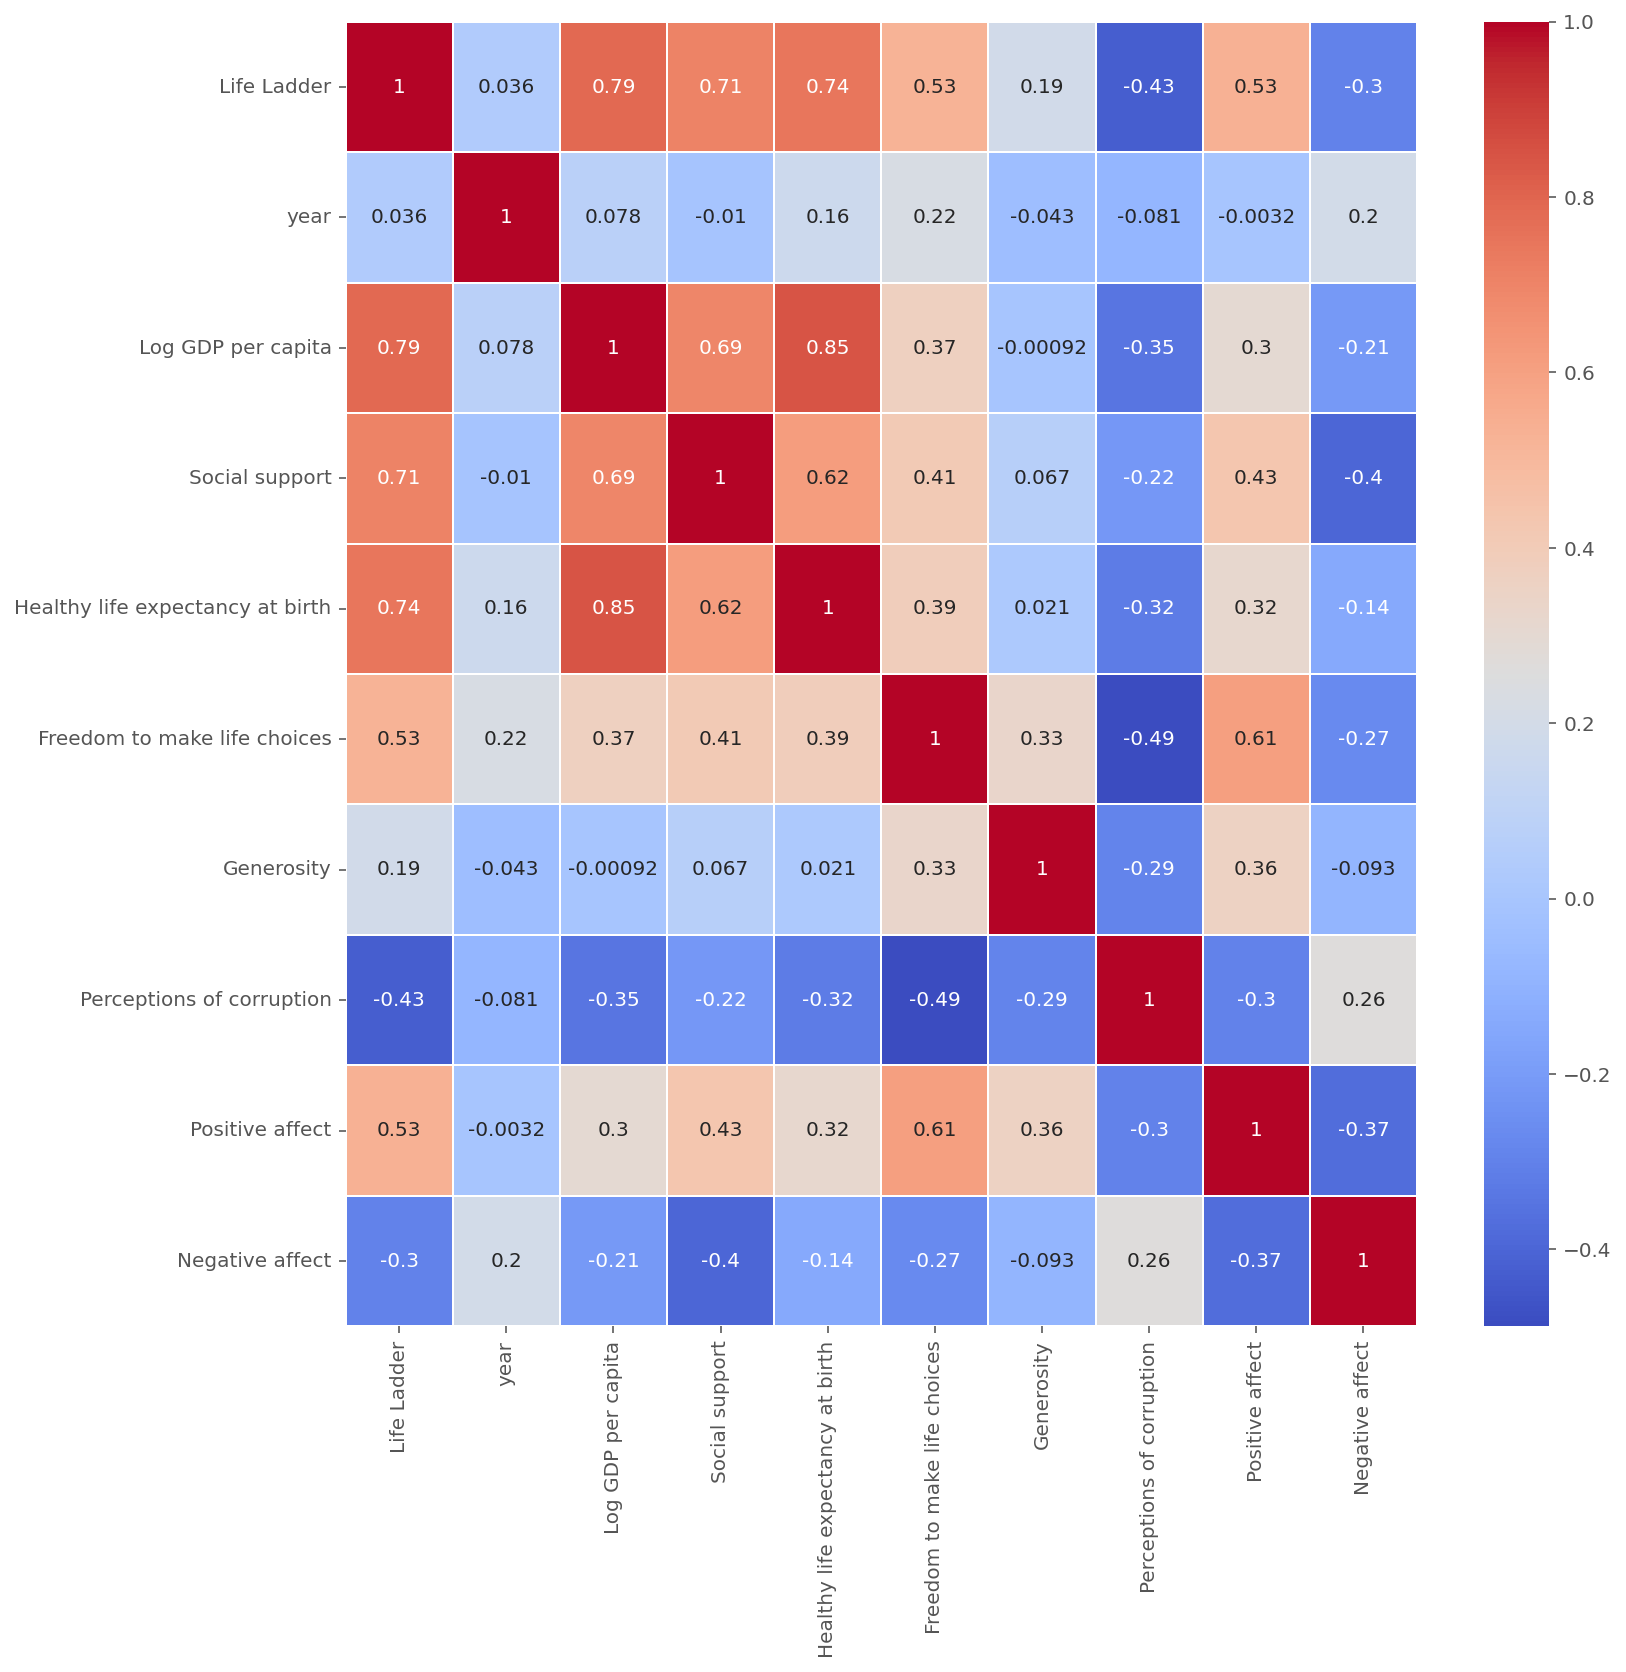

In [10]:
plt.figure(figsize = (12,12))
sns.heatmap(corr, annot=True, cmap='coolwarm', 
            linecolor='white', linewidths=1);

##### Moderate correlations standing out

There are a couple of moderate positive (.5 -.7) correlations. These are between:

- GDP per capita and Social Support (.69)
- GDP per capita and Healthy Life (.85), high positive correlation
- Healthy Life and Social Support (.62)


The collinearity is not as prevalent as expected. Nevertheless, we will find some more data to help us predict the happiness score of a country which isn't yet in the dataset.
At this stage, we note that GDP (log) has a high collinearity with social support and healthy life feature. Provided that this is more of a quantitative feature than a qualitative feature, we will drop this.

### Adding some more data to our dataset

In [11]:
# Importing some alcohol related data
alc = pd.read_csv('alcohol-consumption-vs-gdp-per-capita.csv')

In [12]:
alc.head()

,Entity,Code,Year,"Total alcohol consumption per capita (liters of pure alcohol, projected estimates, 15+ years of age)","GDP per capita, PPP (constant 2017 international $)",Population (historical estimates),Continent
0,Abkhazia,OWID_ABK,2015,NaN,NaN,NaN,Asia
1,Afghanistan,AFG,2010,0.21,1957.029070,29185511.0,NaN
2,Afghanistan,AFG,2015,0.21,2068.265904,34413603.0,Asia
3,Afghanistan,AFG,2018,0.21,2033.804389,37171922.0,NaN
4,Afghanistan,AFG,2002,NaN,1189.784668,22600774.0,NaN


In [13]:
alc.shape

(57084, 7)

In [14]:
# Creating a new dataframe using just Population estimates and
# Total alcohol consumptin per capita
alc_clean = alc.copy()

In [15]:
alc.columns

Index(['Entity', 'Code', 'Year',
       'Total alcohol consumption per capita (liters of pure alcohol, projected estimates, 15+ years of age)',
       'GDP per capita, PPP (constant 2017 international $)',
       'Population (historical estimates)', 'Continent'],
      dtype='object')

In [16]:
#renaming columns
alc_clean.rename(columns = {
    'Total alcohol consumption per capita (liters of pure alcohol, projected estimates, 15+ years of age)':
    'tot_alc_cons',
    'Population (historical estimates)':'population'}, inplace = True)

In [17]:
alc_clean = alc_clean[['Entity', 'Year', 'tot_alc_cons', 'population']]

In [18]:
alc_clean.sample()

,Entity,Year,tot_alc_cons,population
25721,Kazakhstan,1839,NaN,2428374.0


In [19]:
whr.columns

Index(['Country name', 'year', 'Life Ladder', 'Log GDP per capita',
       'Social support', 'Healthy life expectancy at birth',
       'Freedom to make life choices', 'Generosity',
       'Perceptions of corruption', 'Positive affect', 'Negative affect'],
      dtype='object')

In [20]:
#renaming columns to allign names with original dataframe for merging purposes
alc_clean.rename(columns = {'Entity':'Country name',
                           'Year':'year'}, inplace = True)

In [21]:
alc_clean.sample()

,Country name,year,tot_alc_cons,population
55384,Venezuela,1804,NaN,915524.0


In [22]:
alc_clean.dtypes

Country name     object
year              int64
tot_alc_cons    float64
population      float64
dtype: object

In [23]:
# Make a copy of both dfs to avoid loosing anything before joining
df_w = whr.copy()
df_a = alc_clean.copy()

In [24]:
# Finding missing values
df_a.isnull().sum()

Country name        0
year                0
tot_alc_cons    55920
population       1428
dtype: int64

In [25]:
# Newly created alcohol related dataframe
df_a.shape

(57084, 4)

In [26]:
# Original dataframe world happiness report
df_w.dtypes

Country name                         object
year                                  int64
Life Ladder                         float64
Log GDP per capita                  float64
Social support                      float64
Healthy life expectancy at birth    float64
Freedom to make life choices        float64
Generosity                          float64
Perceptions of corruption           float64
Positive affect                     float64
Negative affect                     float64
dtype: object

In [27]:
# Investigating amount of countries
df_a['Country name'].unique()[:20]

array(['Abkhazia', 'Afghanistan', 'Africa', 'Africa Eastern and Southern',
       'Africa Western and Central', 'Akrotiri and Dhekelia', 'Albania',
       'Algeria', 'American Samoa', 'Andorra', 'Angola', 'Anguilla',
       'Antarctica', 'Antigua and Barbuda', 'Arab World', 'Argentina',
       'Armenia', 'Aruba', 'Asia', 'Australia'], dtype=object)

In [28]:
# Investigating available years of data
df_a['year'].unique()[:28]

array([  2015,   2010,   2018,   2002,   2003,   2004,   2005,   2006,
         2007,   2008,   2009,   2011,   2012,   2013,   2014,   2016,
         2017,   2019,   2020, -10000,  -9000,  -8000,  -7000,  -6000,
        -5000,  -4000,  -3000,  -2000])

In [29]:
# Creating a list for all country names in world happiness
# In order to reduce newly created dataframe to relevant data
list_cn_w = list(df_w['Country name'].unique())

In [30]:
# Creating a list for all years in world happiness
# In order to reduce newly created dataframe to relevant data (2005-2020)
list_y_w = list(df_w['year'].unique())
list_y_w

[2008,
 2009,
 2010,
 2011,
 2012,
 2013,
 2014,
 2015,
 2016,
 2017,
 2018,
 2019,
 2007,
 2020,
 2006,
 2005]

In [31]:
# Reducing alcohol dataframe to include same yearly data as Happiness dataframe
df_a = df_a[df_a['year'].isin(list_y_w)].reset_index(drop=True)

In [32]:
df_a.sample()

,Country name,year,tot_alc_cons,population
4453,United States Virgin Islands,2015,NaN,104950.0


In [33]:
# Reducing alcohol dataframe to include same countries as Happiness dataframe
df_a = df_a[df_a['Country name'].isin(list_cn_w)].reset_index(drop=True)

In [34]:
df_a.head()

,Country name,year,tot_alc_cons,population
0,Afghanistan,2010,0.21,29185511.0
1,Afghanistan,2015,0.21,34413603.0
2,Afghanistan,2018,0.21,37171922.0
3,Afghanistan,2005,NaN,25654274.0
4,Afghanistan,2006,NaN,26433058.0


In [35]:
# Verifying missing values in original dataframe
df_w.isnull().sum()

Country name                          0
year                                  0
Life Ladder                           0
Log GDP per capita                   36
Social support                       13
Healthy life expectancy at birth     55
Freedom to make life choices         32
Generosity                           89
Perceptions of corruption           110
Positive affect                      22
Negative affect                      16
dtype: int64

In [36]:
df_w.shape

(1949, 11)

#### First merge of data, adding alcohol related data to our original dataframe

In [37]:
# Merging our two dataframes
df_w = df_w.merge(df_a, on=['Country name', 'year'])

In [38]:
df_w.shape

(1858, 13)

In [39]:
df_w.sample(28)

,Country name,year,Life Ladder,Log GDP per capita,Social support,Healthy life expectancy at birth,Freedom to make life choices,Generosity,Perceptions of corruption,Positive affect,Negative affect,tot_alc_cons,population
932,Lesotho,2011,4.898,7.777,0.824,45.74,0.618,-0.087,0.768,0.793,0.170,NaN,2003793.0
1143,Namibia,2017,4.441,9.215,0.828,56.20,0.810,-0.190,0.831,0.721,0.277,NaN,2402623.0
405,Cuba,2006,5.418,NaN,0.970,68.44,0.281,NaN,NaN,0.647,0.277,NaN,11261241.0
1471,Slovakia,2017,6.366,10.339,0.913,68.60,0.714,-0.055,0.920,0.788,0.213,NaN,5447903.0
613,Greece,2014,4.756,10.257,0.832,71.74,0.369,-0.288,0.930,0.695,0.385,NaN,10701460.0
578,Germany,2008,6.522,10.770,0.923,70.62,0.766,NaN,0.758,0.787,0.220,NaN,81065751.0
1841,Zambia,2019,3.307,8.155,0.638,55.80,0.811,0.077,0.832,0.743,0.394,NaN,17861034.0
810,Jordan,2005,6.295,9.246,0.920,63.50,NaN,NaN,0.670,0.696,0.240,0.66,5765639.0
453,Ecuador,2006,5.024,9.186,0.910,66.08,0.671,-0.091,0.901,0.825,0.357,NaN,14059379.0
1213,Niger,2016,4.235,7.047,0.683,52.50,0.702,-0.016,0.814,0.675,0.325,NaN,20788789.0


In [40]:
# Shape of alcohol data before merge
df_a.shape

(2496, 4)

In [41]:
# Shape of complete data, after merge
df_w.shape

(1858, 13)

In [42]:
# New dataframe missing values
df_w.isna().sum()

Country name                           0
year                                   0
Life Ladder                            0
Log GDP per capita                    19
Social support                        13
Healthy life expectancy at birth      14
Freedom to make life choices          32
Generosity                            70
Perceptions of corruption            109
Positive affect                       22
Negative affect                       16
tot_alc_cons                        1448
population                            14
dtype: int64

##### I am investigating more alcohol data, as 1448 values to impute seems a lot and we could potentially find better data by finding categorical data of alcohol consumption.

We found three datasets of alcohol related data (spiritis, wine, beer) and two additional datasets that are of interest to investigate to us.

In [43]:
### Importing CSVs

# Alcohol related datasets
spirits = pd.read_csv('spirits.csv')
wine = pd.read_csv('wine.csv')
beer = pd.read_csv('beer.csv')

# Other potential datasets
forest = pd.read_csv('forest.csv')
urban = pd.read_csv('urban.csv')

In [44]:
spirits.shape,wine.shape,beer.shape,forest.shape,urban.shape

((10077, 4), (10076, 4), (10077, 4), (7974, 4), (16034, 4))

In [45]:
spirits.sample()

,Entity,Code,Year,"Indicator:Alcohol, recorded per capita (15+) consumption (in litres of pure alcohol) - Beverage Types:Spirits"
9607,United States,USA,1991,2.69


In [46]:
spirits.Year.min()

1960

In [47]:
wine.sample()

,Entity,Code,Year,"Indicator:Alcohol, recorded per capita (15+) consumption (in litres of pure alcohol) - Beverage Types:Wine"
6615,Nigeria,NGA,2019,0.09


In [48]:
beer.sample()

,Entity,Code,Year,"Indicator:Alcohol, recorded per capita (15+) consumption (in litres of pure alcohol) - Beverage Types:Beer"
7337,Qatar,QAT,1974,0.5


In [49]:
forest.sample()

,Entity,Code,Year,Forest cover
116,Algeria,DZA,2013,0.814866


In [50]:
urban.sample()

,Entity,Code,Year,Urban population (% of total population)
10719,Nigeria,NGA,2013,46.118


In [51]:
spirits.columns

Index(['Entity', 'Code', 'Year',
       'Indicator:Alcohol, recorded per capita (15+) consumption (in litres of pure alcohol) - Beverage Types:Spirits'],
      dtype='object')

In [52]:
# Renaming columns
spirits.rename(columns = {
    'Entity':'country', 'Year':'year', 
    'Indicator:Alcohol, recorded per capita (15+) consumption (in litres of pure alcohol) - Beverage Types:Spirits':
    'a_cons'}, inplace=True)

In [53]:
spirits.sample()

,country,Code,year,a_cons
9376,Uganda,UGA,1968,0.22


In [54]:
wine.columns

Index(['Entity', 'Code', 'Year',
       'Indicator:Alcohol, recorded per capita (15+) consumption (in litres of pure alcohol) - Beverage Types:Wine'],
      dtype='object')

In [55]:
wine.rename(columns = {
    'Entity':'country', 'Year':'year',
    'Indicator:Alcohol, recorded per capita (15+) consumption (in litres of pure alcohol) - Beverage Types:Wine':
    'w_cons'}, inplace=True)

In [56]:
wine.sample()

,country,Code,year,w_cons
5863,Micronesia (country),FSM,1979,0.0


In [57]:
beer.columns

Index(['Entity', 'Code', 'Year',
       'Indicator:Alcohol, recorded per capita (15+) consumption (in litres of pure alcohol) - Beverage Types:Beer'],
      dtype='object')

In [58]:
beer.rename(columns = {
    'Entity':'country', 'Year':'year',
    'Indicator:Alcohol, recorded per capita (15+) consumption (in litres of pure alcohol) - Beverage Types:Beer':
    'b_cons'}, inplace=True)

In [59]:
beer.sample()

,country,Code,year,b_cons
3800,Guinea-Bissau,GNB,2014,0.41


In [60]:
forest.columns

Index(['Entity', 'Code', 'Year', 'Forest cover'], dtype='object')

In [61]:
forest.rename(columns = {
    'Entity':'country', 'Year':'year', 'Forest cover':'forest_c'}, inplace=True)

In [62]:
forest.sample()

,country,Code,year,forest_c
6423,Solomon Islands,SLB,1992,90.869882


In [63]:
urban.columns

Index(['Entity', 'Code', 'Year', 'Urban population (% of total population)'], dtype='object')

In [64]:
urban.rename(columns = {
    'Entity':'country', 'Year':'year',
    'Urban population (% of total population)':
    'u_pop'}, inplace=True)

In [65]:
urban.sample()

,country,Code,year,u_pop
7749,Laos,LAO,1971,9.955


In [66]:
# spirits1 = spirits.copy()
# wine1 = wine.copy()
# beer1 = beer.copy()
# forest1 = forest.copy()
# urban1 = urban.copy()

In [67]:
urban.columns

Index(['country', 'Code', 'year', 'u_pop'], dtype='object')

In [68]:
# Clean all CSVs to for list of years in original df
#list_y_w

spirits1 = spirits[spirits['year'].isin(list_y_w)].reset_index(drop=True)
wine1 = wine[wine['year'].isin(list_y_w)].reset_index(drop=True)
beer1 = beer[beer['year'].isin(list_y_w)].reset_index(drop=True)
forest1 = forest[forest['year'].isin(list_y_w)].reset_index(drop=True)
urban1 = urban[urban['year'].isin(list_y_w)].reset_index(drop=True)

In [69]:
wine1.sample()

,country,Code,year,w_cons
556,Comoros,COM,2006,0.01862


In [70]:
spirits.rename(columns={'Country name':'country'}, inplace=True)

In [71]:
spirits.columns

Index(['country', 'Code', 'year', 'a_cons'], dtype='object')

In [72]:
# Filtering countries to include same countries as in original df
#list_cn_w

spirits = spirits[spirits['country'].isin(list_cn_w)].reset_index(drop=True)
wine = wine[wine['country'].isin(list_cn_w)].reset_index(drop=True)
beer = beer[beer['country'].isin(list_cn_w)].reset_index(drop=True)
forest = forest[forest['country'].isin(list_cn_w)].reset_index(drop=True)
urban = urban[urban['country'].isin(list_cn_w)].reset_index(drop=True)

In [73]:
# Creating copies of all newly created dfs to not loose anything while merging
sp = spirits.copy()
wi = wine.copy()
be = beer.copy()
fo = forest.copy()
ur = urban.copy()

In [74]:
sp.shape, wi.shape, be.shape, fo.shape, ur.shape

((8371, 4), (8370, 4), (8371, 4), (4744, 4), (9455, 4))

#### Create a dataframe from all previously imported CSVs (5)

In [75]:
# Merging spritis with wine
spwi = sp.merge(wi, on=['country', 'year'])

In [76]:
spwi.shape

(8370, 6)

In [77]:
spwi.sample(5)

,country,Code_x,year,a_cons,Code_y,w_cons
1255,Cambodia,KHM,2018,0.42,KHM,0.02
7157,Sweden,SWE,1979,3.78,SWE,1.29
4868,Mexico,MEX,1973,0.79,MEX,0.04
4441,Madagascar,MDG,1979,1.12,MDG,0.19
3025,Haiti,HTI,1993,4.71,HTI,0.00


In [78]:
# Merging spirits and wine with beer
spwibe = spwi.merge(be, on=['country','year'])

In [79]:
spwibe.shape

(8370, 8)

In [80]:
spwibe.sample(5)

,country,Code_x,year,a_cons,Code_y,w_cons,Code,b_cons
6044,Philippines,PHL,2017,3.33000,PHL,0.03000,PHL,1.38000
821,Bhutan,BTN,2002,0.00000,BTN,0.00588,BTN,0.29329
3032,Haiti,HTI,2000,3.44647,HTI,0.03710,HTI,0.14212
4563,Malaysia,MYS,1983,0.16000,MYS,0.00000,MYS,0.49000
5681,Norway,NOR,2008,1.33000,NOR,2.23000,NOR,3.06000


In [81]:
# Comparing shapes of all dataframes we will be merging.
sp.shape, wi.shape, be.shape, fo.shape, ur.shape

((8371, 4), (8370, 4), (8371, 4), (4744, 4), (9455, 4))

In [82]:
spwibefo = spwibe.merge(fo, on=['country','year'])

/Users/cristianravalli/opt/anaconda3/lib/python3.9/site-packages/pandas/core/frame.py:9190: FutureWarning: Passing 'suffixes' which cause duplicate columns {'Code_x'} in the result is deprecated and will raise a MergeError in a future version.
  return merge(


In [83]:
spwibefo.sample(5)

,country,Code_x,year,a_cons,Code_y,w_cons,Code_x,b_cons,Code_y,forest_c
3386,Russia,RUS,2000,7.30900,RUS,0.70884,RUS,2.19153,RUS,49.415334
3094,Oman,OMN,2010,0.28000,OMN,0.03000,OMN,0.20000,OMN,0.009693
3069,Norway,NOR,2015,1.03000,NOR,2.22000,NOR,2.57000,NOR,33.251812
2031,Jordan,JOR,2009,0.35151,JOR,0.02409,JOR,0.17486,JOR,1.098220
602,Bulgaria,BGR,2015,4.62000,BGR,1.95000,BGR,4.22000,BGR,35.307664


In [84]:
spwibefour = spwibefo.merge(ur, on=['country','year'])

In [85]:
spwibefour.sample(5)

,country,Code_x,year,a_cons,Code_y,w_cons,Code_x,b_cons,Code_y,forest_c,Code,u_pop
4142,Uganda,UGA,1999,0.18000,UGA,0.00000,UGA,0.47000,UGA,15.979463,UGA,14.379
3243,Philippines,PHL,2005,2.89252,PHL,0.01200,PHL,1.28721,PHL,23.726364,PHL,45.710
2208,Latvia,LVA,2012,3.77000,LVA,1.16000,LVA,4.67000,LVA,54.417131,LVA,67.897
453,Bhutan,BTN,2014,0.16000,BTN,0.00000,BTN,0.04000,BTN,71.130505,BTN,37.918
3526,Sierra Leone,SLE,2006,0.01058,SLE,0.15114,SLE,0.13536,SLE,38.945248,SLE,37.303


In [86]:
list_y_w = list(df_w['year'].unique())

In [87]:
list_y_w

[2008,
 2009,
 2010,
 2011,
 2012,
 2013,
 2014,
 2015,
 2016,
 2017,
 2018,
 2019,
 2007,
 2020,
 2006,
 2005]

In [88]:
# Reducing yearly data to the same range as in original dataframe
spwibefour = spwibefour[spwibefour['year'].isin(
    list_y_w)].reset_index(drop=True)

In [89]:
spwibefour.sample(5)

,country,Code_x,year,a_cons,Code_y,w_cons,Code_x,b_cons,Code_y,forest_c,Code,u_pop
525,Cyprus,CYP,2005,4.99983,CYP,2.78991,CYP,3.62488,CYP,18.639069,CYP,68.268
1052,Kenya,KEN,2007,0.21820,KEN,0.02503,KEN,0.94786,KEN,6.535817,KEN,22.420
1916,Spain,ESP,2018,2.30000,ESP,3.33000,ESP,4.57000,ESP,37.161190,ESP,80.321
1,Afghanistan,AFG,2006,0.00685,AFG,0.00786,AFG,0.01147,AFG,1.850994,AFG,22.907
1499,Nicaragua,NIC,2005,2.51404,NIC,0.01528,NIC,1.11538,NIC,39.834926,NIC,55.935


In [90]:
spwibefour.shape

(2293, 12)

In [91]:
moref = spwibefour.copy()

In [92]:
moref.columns

Index(['country', 'Code_x', 'year', 'a_cons', 'Code_y', 'w_cons', 'Code_x',
       'b_cons', 'Code_y', 'forest_c', 'Code', 'u_pop'],
      dtype='object')

In [93]:
# Removing 'Code.' columns created through merging
moref1 = moref[['country','year', 'a_cons', 'w_cons',
       'b_cons', 'forest_c', 'u_pop']]

In [94]:
moref1

,country,year,a_cons,w_cons,b_cons,forest_c,u_pop
0,Afghanistan,2005,0.00605,0.00084,0.00934,1.850994,22.703
1,Afghanistan,2006,0.00685,0.00786,0.01147,1.850994,22.907
2,Afghanistan,2007,0.00202,0.00887,0.00713,1.850994,23.113
3,Afghanistan,2008,0.01809,0.00089,0.00857,1.850994,23.320
4,Afghanistan,2009,0.00000,0.00000,0.00972,1.850994,23.528
...,...,...,...,...,...,...,...
2288,Zimbabwe,2015,0.36000,0.06000,1.93000,45.689363,32.385
2289,Zimbabwe,2016,0.35000,0.05000,1.93000,45.570273,32.296
2290,Zimbabwe,2017,0.39000,0.05000,1.93000,45.451183,32.237
2291,Zimbabwe,2018,0.39000,0.04000,1.20000,45.332093,32.209


### Second merge to increase my original data frame by 5 more datasets

In [95]:
# Copies of my two original dataframes

original = df_w.copy()
features2 = moref1.copy()

In [96]:
original.shape, features2.shape

((1858, 13), (2293, 7))

In [97]:
original.sample()

,Country name,year,Life Ladder,Log GDP per capita,Social support,Healthy life expectancy at birth,Freedom to make life choices,Generosity,Perceptions of corruption,Positive affect,Negative affect,tot_alc_cons,population
1726,United Arab Emirates,2017,7.039,11.115,0.836,66.9,0.962,0.216,NaN,0.795,0.208,NaN,9487206.0


In [98]:
features2.sample()

,country,year,a_cons,w_cons,b_cons,forest_c,u_pop
2131,Ukraine,2008,5.24293,0.48396,3.59742,16.468842,68.325


In [99]:
# rename Country name column into country for original dataframe
original.rename(columns={'Country name':'country'}, inplace=True)

In [100]:
original.sample()

,country,year,Life Ladder,Log GDP per capita,Social support,Healthy life expectancy at birth,Freedom to make life choices,Generosity,Perceptions of corruption,Positive affect,Negative affect,tot_alc_cons,population
1683,Turkmenistan,2016,5.887,9.515,0.929,61.4,0.749,0.005,NaN,0.636,0.255,NaN,5662371.0


In [101]:
# Merging my to dataframe to get my new complete dataframe

In [102]:
complete_df = original.merge(features2, on=['country', 'year'])

In [103]:
# Showing all columns of new dataframe
complete_df.sample().T

,536
country,Georgia
year,2010
Life Ladder,4.102
Log GDP per capita,9.184
Social support,0.54
Healthy life expectancy at birth,64.8
Freedom to make life choices,0.558
Generosity,-0.248
Perceptions of corruption,0.46
Positive affect,0.502


In [104]:
complete_df.columns

Index(['country', 'year', 'Life Ladder', 'Log GDP per capita',
       'Social support', 'Healthy life expectancy at birth',
       'Freedom to make life choices', 'Generosity',
       'Perceptions of corruption', 'Positive affect', 'Negative affect',
       'tot_alc_cons', 'population', 'a_cons', 'w_cons', 'b_cons', 'forest_c',
       'u_pop'],
      dtype='object')

In [105]:
# clean up all columns into country for original dataframe
complete_df.rename(columns={'Life Ladder':'happiness_s',
                           'Log GDP per capita':'log_gdp',
                           'Social support':'social_s',
                           'Healthy life expectancy at birth':'life_ex',
                           'Freedom to make life choices':'life_choices',
                           'Generosity':'generosity',
                           'Perceptions of corruption':'corruption',
                           'Positive affect':'positive_a',
                           'Negative affect':'negative_a',
                           'a_cons':'spirit_c',
                           'w_cons':'wine_c',
                           'b_cons':'beer_c'}, inplace=True)

In [106]:
complete_df.shape

(1745, 18)

In [107]:
complete_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1745 entries, 0 to 1744
Data columns (total 18 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   country       1745 non-null   object 
 1   year          1745 non-null   int64  
 2   happiness_s   1745 non-null   float64
 3   log_gdp       1735 non-null   float64
 4   social_s      1732 non-null   float64
 5   life_ex       1745 non-null   float64
 6   life_choices  1715 non-null   float64
 7   generosity    1684 non-null   float64
 8   corruption    1642 non-null   float64
 9   positive_a    1725 non-null   float64
 10  negative_a    1730 non-null   float64
 11  tot_alc_cons  410 non-null    float64
 12  population    1745 non-null   float64
 13  spirit_c      1745 non-null   float64
 14  wine_c        1745 non-null   float64
 15  beer_c        1745 non-null   float64
 16  forest_c      1745 non-null   float64
 17  u_pop         1745 non-null   float64
dtypes: float64(16), int64(1), ob

##### Investigating some more predictors

In [108]:
# Importing three more data files to increase my potential features

education = pd.read_csv('no education_share.csv')
women = pd.read_csv('women_mgmt.csv')
adep = pd.read_csv('age_dependency.csv')

In [109]:
education.shape,women.shape,adep.shape

((1865, 4), (1016, 4), (14720, 4))

In [110]:
education.sample()

,Entity,Code,Year,IIASA rates of no education projections (IIASA (2015))
295,Chad,TCD,2050,19.973283


In [111]:
women.sample()

,Entity,Code,Year,5.5.2 - Proportion of women in senior and middle management positions (%) - IC_GEN_MGTN
971,United States,USA,2003,37.38


In [112]:
adep.sample()

,Entity,Code,Year,Age dependency ratio (% of working-age population)
7803,Lithuania,LTU,1967,57.995854


In [113]:
education.shape, women.shape, adep.shape

((1865, 4), (1016, 4), (14720, 4))

In [114]:
women['Year'].unique()

array([2017, 2007, 2008, 2009, 2010, 2012, 2013, 2014, 2015, 2016, 2018,
       2019, 2004, 2005, 2006, 2011, 2000, 2001, 2002, 2003, 2020])

In [115]:
adep['Year'].unique()

array([1960, 1961, 1962, 1963, 1964, 1965, 1966, 1967, 1968, 1969, 1970,
       1971, 1972, 1973, 1974, 1975, 1976, 1977, 1978, 1979, 1980, 1981,
       1982, 1983, 1984, 1985, 1986, 1987, 1988, 1989, 1990, 1991, 1992,
       1993, 1994, 1995, 1996, 1997, 1998, 1999, 2000, 2001, 2002, 2003,
       2004, 2005, 2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014,
       2015, 2016, 2017, 2018, 2019, 2020])

In [116]:
# Make a copy of both dfs to avoid loosing anything
edu = education.copy()
wom = women.copy()
dep = adep.copy()

In [117]:
# Alligning year columns data with original dataframe (2005-2020)
dep = dep[dep['Year'].isin(list_y_w)].reset_index(drop=True)

In [118]:
dep.sample()

,Entity,Code,Year,Age dependency ratio (% of working-age population)
46,Africa Western and Central,NaN,2019,86.085806


In [119]:
# Alligning country columns data with original dataframe
dep = dep[dep['Entity'].isin(list_cn_w)].reset_index(drop=True)

In [120]:
dep.sample()

,Entity,Code,Year,Age dependency ratio (% of working-age population)
950,India,IND,2011,55.208637


Repeating the same steps for the subsequent datasets, as previously set out.

In [121]:
edu = edu[edu['Year'].isin(list_y_w)].reset_index(drop=True)

In [122]:
edu.sample()

,Entity,Code,Year,IIASA rates of no education projections (IIASA (2015))
88,Cote d'Ivoire,CIV,2010,45.961186


In [123]:
edu = edu[edu['Entity'].isin(list_cn_w)].reset_index(drop=True)

In [124]:
edu.sample()

,Entity,Code,Year,IIASA rates of no education projections (IIASA (2015))
326,Spain,ESP,2010,11.539247


Repeating the same steps for the subsequent datasets, as previously set out.

In [125]:
wom = wom[wom['Year'].isin(list_y_w)].reset_index(drop=True)

In [126]:
wom.Entity.value_counts()

United States      16
Greece             15
Romania            15
Ecuador            15
Estonia            15
                   ..
Guyana              1
Solomon Islands     1
Gambia              1
Suriname            1
Afghanistan         1
Name: Entity, Length: 116, dtype: int64

In [127]:
wom = wom[wom['Entity'].isin(list_cn_w)].reset_index(drop=True)

In [128]:
wom.sample()

,Entity,Code,Year,5.5.2 - Proportion of women in senior and middle management positions (%) - IC_GEN_MGTN
768,United States,USA,2014,38.8


In [129]:
# Verifying the shapes of our newly acquired data
edu.shape,wom.shape,dep.shape

((389, 4), (796, 4), (2480, 4))

In [130]:
# Starting merging dataframes two at the time
depwom = dep.merge(wom, on=['Entity', 'Year'], how='outer')

In [131]:
depwom.shape

(2480, 6)

In [132]:
depwomedu = depwom.merge(edu, on=['Entity', 'Year'], how='outer')

In [133]:
depwomedu.shape

(2480, 8)

In [134]:
depwomedu

,Entity,Code_x,Year,Age dependency ratio (% of working-age population),Code_y,5.5.2 - Proportion of women in senior and middle management positions (%) - IC_GEN_MGTN,Code,IIASA rates of no education projections (IIASA (2015))
0,Afghanistan,AFG,2005,100.349127,NaN,NaN,NaN,NaN
1,Afghanistan,AFG,2006,100.970943,NaN,NaN,NaN,NaN
2,Afghanistan,AFG,2007,101.600182,NaN,NaN,NaN,NaN
3,Afghanistan,AFG,2008,102.078659,NaN,NaN,NaN,NaN
4,Afghanistan,AFG,2009,102.249014,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...
2475,Zimbabwe,ZWE,2016,83.576729,NaN,NaN,NaN,NaN
2476,Zimbabwe,ZWE,2017,83.466245,NaN,NaN,NaN,NaN
2477,Zimbabwe,ZWE,2018,82.951113,NaN,NaN,NaN,NaN
2478,Zimbabwe,ZWE,2019,82.277964,ZWE,28.07,NaN,NaN


In [135]:
# Cleaning up our df by dropping columns starting with "Code"
df_new = depwomedu[depwomedu.columns[~depwomedu.columns.str.startswith(
    'Code')]]

In [136]:
df_new.sample()

,Entity,Year,Age dependency ratio (% of working-age population),5.5.2 - Proportion of women in senior and middle management positions (%) - IC_GEN_MGTN,IIASA rates of no education projections (IIASA (2015))
202,Belgium,2015,54.193606,31.04,NaN


In [137]:
df_new.columns

Index(['Entity', 'Year', 'Age dependency ratio (% of working-age population)',
       '5.5.2 - Proportion of women in senior and middle management positions (%) - IC_GEN_MGTN',
       'IIASA rates of no education projections (IIASA (2015))'],
      dtype='object')

In [138]:
df_clean = df_new.copy()
# Renaming columns to merge on country name and year
df_clean = df_new.rename(columns= {
    'Entity':'country', 'Year':'year', 'Age dependency ratio (% of working-age population)':'age_dr',
       '5.5.2 - Proportion of women in senior and middle management positions (%) - IC_GEN_MGTN':'women_mgmt',
       'IIASA rates of no education projections (IIASA (2015))':'r_noedu'})

In [139]:
df_clean.head()

,country,year,age_dr,women_mgmt,r_noedu
0,Afghanistan,2005,100.349127,NaN,NaN
1,Afghanistan,2006,100.970943,NaN,NaN
2,Afghanistan,2007,101.600182,NaN,NaN
3,Afghanistan,2008,102.078659,NaN,NaN
4,Afghanistan,2009,102.249014,NaN,NaN


In [140]:
features3 = df_clean.copy()

In [141]:
# Comparing our 3 feature df with our previously merged and complete dataset
features3.shape, complete_df.shape

((2480, 5), (1745, 18))

In [142]:
protect_c_df = complete_df.copy()

In [143]:
# Merging
df_20f = complete_df.merge(features3, on=['country', 'year'])

In [144]:
df_20f.shape

(1745, 21)

In [145]:
df_20f.sample(3)

,country,year,happiness_s,log_gdp,social_s,life_ex,life_choices,generosity,corruption,positive_a,...,tot_alc_cons,population,spirit_c,wine_c,beer_c,forest_c,u_pop,age_dr,women_mgmt,r_noedu
1378,Singapore,2018,6.375,11.490,0.903,76.80,0.916,-0.066,0.097,0.787,...,2.03,5757503.0,0.27,0.30,1.25,22.469111,100.000,31.133213,NaN,NaN
221,Brazil,2019,6.451,9.592,0.899,66.60,0.830,-0.062,0.762,0.761,...,NaN,211049519.0,2.00,0.24,3.84,59.591325,86.824,43.391382,38.61,NaN
930,Malawi,2013,4.035,6.907,0.563,53.46,0.752,0.078,0.857,0.808,...,NaN,15839287.0,0.23,0.00,0.17,26.895418,15.966,93.786360,NaN,NaN


In [146]:
#number of numerical and string columns

num_cols = df_20f.select_dtypes('number').columns
cat_cols = df_20f.select_dtypes('object').columns

print(f"The total number of numerical columns is {len(num_cols)}.")
print(f"The total number of object (categorical) columns is {len(cat_cols)}.")

The total number of numerical columns is 20.
The total number of object (categorical) columns is 1.


In [147]:
# Create a csv from dataframe
df_20f.to_csv('df_20f.csv')

## Data Dictionary

In [148]:
# My final dataframe
eda_start = df_20f.copy()

In [149]:
'Import Excel spreadsheet with manually created data dictionary columns columns.'

data_dictionary = pd.read_excel('data_dictionary_whi.xlsx')

In [150]:
data_dictionary.head(3)

,# Columns,Column Name,Full Name,Data Format,Data Range,Description
0,1.0,country,Country Name,object,none,Official Name of the Country in Question
1,2.0,year,Year,int64,2005-2020,Year of the Data Observed
2,3.0,log_gdp,GDP per capita,float64,6.635 - 11.648,"GDP per capita in terms of PPP, taken from Wor..."


In [151]:
data_dictionary.sample()

,# Columns,Column Name,Full Name,Data Format,Data Range,Description
24,?,d_dystopia,Distance from Dystopia,float64,NaN,NaN


In [152]:
# Only start with dataframe from 2 colomn onwards
data_dictionary[['Column Name', 'Description']]

,Column Name,Description
0,country,Official Name of the Country in Question
1,year,Year of the Data Observed
2,log_gdp,"GDP per capita in terms of PPP, taken from Wor..."
3,social_s,"If in trouble, are there relatives or friends ..."
4,life_choices,If a person is satisfied or dissatiesfied with...
5,generosity,Whether a person have given money to charity i...
6,corruption,Perception of corruption within government and...
7,positive_a,"Average of previous-day affect of happiness, l..."
8,negative_a,"Average of previous-day affect of worries, sad..."
9,tot_alc_cons,"Average yearly alcohol consumption, reported i..."
